In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import CosineSimilarity

import pandas as pd
import numpy as np
import torchtext
import os
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from utils import train, compute_accuracy, plot_scores
import matplotlib.pyplot as plt

seed = 265
torch.manual_seed(seed)

In [2]:
DEVICE = (
    torch.device('cuda') if torch.cuda.is_available()
    else torch.device('cpu'))
print(f"On device {DEVICE}.")

On device cpu.


In [3]:
using_colab = False

COLAB_PATH = "/content/drive/MyDrive/project3/"
PATH_GENERATED_EMBS = "generated/word_embeddings/" if not using_colab else COLAB_PATH + "generated/word_embeddings/"
PATH_DATA = "data/" if not using_colab else COLAB_PATH + "data/"

In [4]:
# tokenizer will split a long text into a list of english words
TOKENIZER_EN = get_tokenizer('basic_english')
# Where we will store / load all our models, datasets, vocabulary, etc.
PATH_GENERATED = './generated/word_embeddings/'
# Minimum number of occurence of a word in the text to add it to the vocabulary
MIN_FREQ = 100
DEBUG = True

def read_files(datapath=PATH_DATA + 'data_train/'):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory 
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]

    if DEBUG:
        files = [files[0]]    
        
    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[0-9]+\w*'
    # Match word containing a uppercase 
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'
    
    for line in lines:
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    
    Useful to get some insight on the data and to compute loss weights
    """
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=["<unk>"])
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [5]:
# ----------------------- Tokenize texts -------------------------------
# Load tokenized versions of texts if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(PATH_GENERATED_EMBS + "words_train.pt"):
    words_train = torch.load(PATH_GENERATED_EMBS + "words_train.pt")
    words_val = torch.load(PATH_GENERATED_EMBS + "words_val.pt")
    words_test = torch.load(PATH_GENERATED_EMBS + "words_test.pt")
else:
    # Get lists of strings, one for each line in each .txt files in 'datapath' 
    lines_books_train = read_files(PATH_DATA + 'data_train/')
    lines_books_val = read_files(PATH_DATA + 'data_val/')
    lines_books_test = read_files(PATH_DATA + 'data_test/')

    # List of words contained in the dataset
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)
    
    torch.save(words_train , PATH_GENERATED_EMBS + "words_train.pt")
    torch.save(words_val , PATH_GENERATED_EMBS + "words_val.pt")
    torch.save(words_test , PATH_GENERATED_EMBS + "words_test.pt")



# ----------------------- Create vocabulary ----------------------------
VOCAB_FNAME = "vocabulary.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(PATH_GENERATED_EMBS + VOCAB_FNAME):
    vocab = torch.load(PATH_GENERATED_EMBS + VOCAB_FNAME)
else:
    # Create vocabulary based on the words in the training dataset
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    torch.save(vocab, PATH_GENERATED_EMBS + VOCAB_FNAME)
    

# ------------------------ Quick analysis ------------------------------
VOCAB_SIZE = len(vocab)
print("Total number of words in the training dataset:     ", len(words_train))
print("Total number of words in the validation dataset:   ", len(words_val))
print("Total number of words in the test dataset:         ", len(words_test))
print("Number of distinct words in the training dataset:  ", len(set(words_train)))
print("Number of distinct words kept (vocabulary size):   ", VOCAB_SIZE)

freqs = count_freqs(words_train, vocab)

class_weights = 1/freqs
torch.save(class_weights, PATH_GENERATED_EMBS + 'class_weights.pt')

occurences = [(f.item(), w) for (f, w)  in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))]
print("occurences:\n", occurences)

Total number of words in the training dataset:      2684706
Total number of words in the validation dataset:    49526
Total number of words in the test dataset:          124152
Number of distinct words in the training dataset:   52105
Number of distinct words kept (vocabulary size):    1880
occurences:
 [(433907, '<unk>'), (182537, ','), (151278, 'the'), (123727, '.'), (82289, 'and'), (65661, 'of'), (62763, 'to'), (49230, 'a'), (41477, 'in'), (31052, 'that'), (37167, 'he'), (29046, 'was'), (26508, 'his'), (26354, 'it'), (20862, 'with'), (20159, 'had'), (19965, 'is'), (15692, 'not'), (16593, 'as'), (15705, 'on'), (14464, 'him'), (15317, 'for'), (15838, 'at'), (15952, 'you'), (13255, 'be'), (12698, 'her'), (12798, 's'), (11924, 'which'), (11808, '!'), (11740, 'all'), (10338, '?'), (10205, 'have'), (10405, 'from'), (13251, 'but'), (11464, 'this'), (9439, 'by'), (11496, 'they'), (8797, 'said'), (8800, 'are'), (11055, 'she'), (9537, 'one'), (8219, 'were'), (8564, 'who'), (8345, 'so'), (9409

In [6]:
# context size for this task 
CONTEXT_SIZE = 4

# ---------------- Define context / target pairs -----------------------
def create_dataset(
    text, vocab, 
    context_size=CONTEXT_SIZE, map_target=None
):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    n_vocab = len(vocab)
    
    # Change labels if only a few target are kept, otherwise, each word is
    # associated with its index in the vocabulary
    if map_target is None:
        map_target = {i:i for i in range(n_vocab)}
    
    # Transform the text as a list of integers.
    txt = [vocab[w] for w in text]

    # Start constructing the context / target pairs...
    contexts = []
    targets = []

    for i in range(n_text - context_size):
    
        # Context before the target
        c_pre = txt[i:i + int(context_size/2)]
        c_post = txt[i + int(context_size/2 + 1) : i + int(context_size + 1)]
        c = c_pre + c_post
 
        # Word used to define target
        t = txt[i + int(context_size/2)]
        
        targets.append(map_target[t])
        contexts.append(torch.tensor(c))
        
    # contexts of shape (N_dataset, context_size)
    # targets of shape  (N_dataset)
    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    # Create a pytorch dataset out of these context / target pairs
    return TensorDataset(contexts, targets)

In [7]:
def load_dataset(words, vocab, fname):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED_EMBS + fname):
        dataset = torch.load(PATH_GENERATED_EMBS + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED_EMBS + fname)
    return dataset

data_train = load_dataset(words_train, vocab, "data_train.pt")
data_val = load_dataset(words_val, vocab, "data_val.pt")
data_test = load_dataset(words_test, vocab, "data_test.pt")

In [8]:
class simple_eTrain(nn.Module):
    
    def __init__(self, context_size=CONTEXT_SIZE):
        super().__init__()
        
        (vocab_size, embedding_dim) = (VOCAB_SIZE, 10)
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Regular MLP
        self.fc1 = nn.Linear(embedding_dim*context_size, 128)
        self.fc2 = nn.Linear(128, VOCAB_SIZE)

    def forward(self, x):
        # adds a trainable embedding layer
        out = self.embedding(x)
        # out is now of shape (N, context_size, embedding_dim)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        # out is now of shape (N, context_size*embedding_dim)
        
        out = self.fc2(out)
        return out

In [9]:
class medium_eTrain(nn.Module):
    
    def __init__(self, context_size=CONTEXT_SIZE):
        super().__init__()
        
        (vocab_size, embedding_dim) = (VOCAB_SIZE, 10)
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Regular MLP
        self.fc1 = nn.Linear(embedding_dim*context_size, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512,VOCAB_SIZE)

    def forward(self, x):
        # adds a trainable embedding layer
        out = self.embedding(x)
        # out is now of shape (N, context_size, embedding_dim)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        # out is now of shape (N, context_size*embedding_dim)

        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        
        return out

In [10]:
class complex_eTrain(nn.Module):
    
    def __init__(self, context_size=CONTEXT_SIZE):
        super().__init__()
        
        (vocab_size, embedding_dim) = (VOCAB_SIZE, 10)
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Regular MLP
        self.fc1 = nn.Linear(embedding_dim*context_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, VOCAB_SIZE)

    def forward(self, x):
        # adds a trainable embedding layer
        out = self.embedding(x)
        # out is now of shape (N, context_size, embedding_dim)
        out = F.relu(self.fc1(torch.flatten(out, 1)))
        # out is now of shape (N, context_size*embedding_dim)

        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = F.relu(self.fc4(out))
        out = self.fc5(out)
        
        return out

### Model selection

In [11]:
torch.manual_seed(seed)

MODEL_FNAME = "embedding_model.pt"

batch_size=512
n_epochs=50

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

class_weights = torch.load(PATH_GENERATED_EMBS + 'class_weights.pt').to(DEVICE)

simple = simple_eTrain()
medium = medium_eTrain()
complex = complex_eTrain()


models = [complex, medium, simple]
stats = []

if os.path.isfile(PATH_GENERATED_EMBS + MODEL_FNAME):
    # Load the trained model
    model = torch.load(PATH_GENERATED_EMBS + MODEL_FNAME)
    model.to(DEVICE)
else:
    for model in models:
        # Or train the model...
        print(f'Trianing {model.__class__.__name__ }:')
        model.to(DEVICE)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)

        loss_list , val_list = train(n_epochs, optimizer, model, train_loader, val_loader, loss_fn, device=DEVICE)

        acc = compute_accuracy(model, val_loader, device=DEVICE)
        stats.append((acc, loss_list, val_list))

        print()
        print(f'Validation accuracy: {acc}')
        print()
        print('------------------------------------------------------------------')
        print()

    # Pick best model based on validation accuracy
    best_model = models[stats.index(max(stats, key=lambda x: x[0]))]
    test_acc = compute_accuracy(best_model, test_loader, device=DEVICE)
    best_model_stats = max(stats, key=lambda x: x[0])[1:]

    print(f'The best model was {best_model.__class__.__name__ }')
    print(f'Test accuracy of the best model: {test_acc}')

    # ... and save it
    torch.save(best_model.to(device="cpu"), PATH_GENERATED_EMBS + MODEL_FNAME)
    torch.save(best_model.embedding, PATH_GENERATED_EMBS + 'embedding.pt')
    torch.save(best_model_stats, PATH_GENERATED_EMBS + 'best_model_stats.pt')

In [12]:
def test_model(model, data_test):
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)
    acc = compute_accuracy(model, test_loader, device=DEVICE)
    return acc*100

print(f'The best model was {model.__class__.__name__ }')
print()
print("=====================================================")
print("Accuracy of the best embedding model on test set:")
print("=====================================================")
print(f"{round(test_model(model, data_test),4)}%")

The best model was simple_eTrain

Accuracy of the best embedding model on test set:
4.9691%


### Createing cosine similarity matrix and finds 10 most similar words for each word in a selected set

In [13]:
embedding = torch.load(PATH_GENERATED_EMBS + 'embedding.pt')

cosine_sim = nn.CosineSimilarity(dim=1)
embedding_matrix = embedding.weight.data

In [14]:
sim_matrix = []
# Create the similarity matrix
for word in embedding_matrix:
    sim = cosine_sim(word, embedding_matrix)
    sim_matrix.append(sim)

sim_matrix = torch.stack(sim_matrix)

selected_words = ['king', 'child', 'woman', 'man', 'can']
for word in selected_words:
    idx = vocab[word]
    most_similar_idx = torch.topk(sim_matrix[idx], 11)[1]
    most_similar_idx = most_similar_idx[1:]                                 # We remove the first element as this is the same word
    most_similar_wrd = [vocab.lookup_token(x) for x in most_similar_idx]
    print(f'The ten most similar words to \033[91m{word}\033[0m is:\n {most_similar_wrd}')
    print()

The ten most similar words to king is:
 ['earl', 'queen', 'father', 'brother', 'sister', 'mother', 'peasant', 'commander', 'plan', 'order']

The ten most similar words to child is:
 ['heart', 'name', 'convict', 'man', 'woman', 'children', 'wound', 'sovereign', 'dream', 'soul']

The ten most similar words to woman is:
 ['wife', 'lady', 'friend', 'fellow', 'count', 'boy', 'father', 'women', 'grandfather', 'daughter']

The ten most similar words to man is:
 ['beast', 'person', 'hearts', 'heart', 'soul', 'child', 'woman', 'reader', 'conscience', 'beings']

The ten most similar words to can is:
 ['could', 'might', 'will', 'll', 'would', 'may', 'cannot', 'must', 'should', 'shall']



In [15]:
# Save vocab and embeddings as .tsv for visualization
# First transform to pandas dataframe

embedding_pd = pd.DataFrame(embedding_matrix)
embedding_pd.to_csv(PATH_GENERATED_EMBS + 'embedding.tsv', sep='\t', header=None, index=None)

vocab_pd = pd.DataFrame([vocab.lookup_token(x) for x in range(len(vocab))])

vocab_pd.to_csv(PATH_GENERATED_EMBS + 'vocab.tsv', sep='\t', header=None, index=None)

## Visualization of Loss and Validation Performance

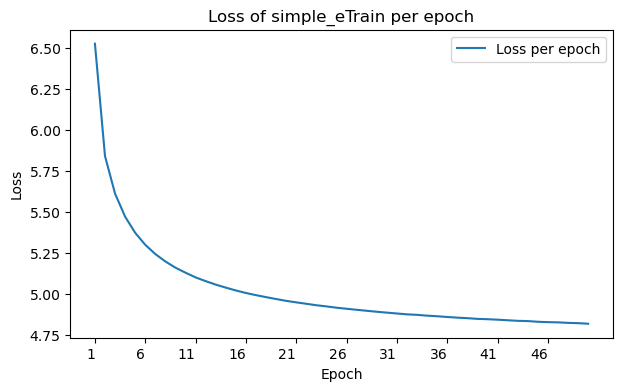

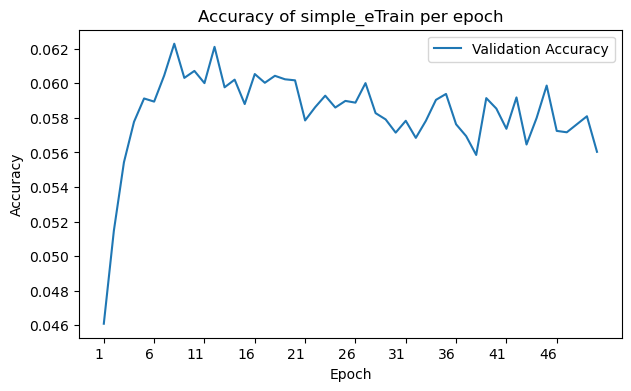

In [16]:
losses, val_performance = torch.load(PATH_GENERATED_EMBS + 'best_model_stats.pt')
best_model = torch.load(PATH_GENERATED_EMBS + MODEL_FNAME)

plot_scores(best_model, losses)
plot_scores(best_model, val_performance, loss=False)